# Background

In this notebook, I simulate a set of 100 diploid individuals under a constant effective size and perform Ne inference using the developed approach. 

In [1]:
params = {
    "sample_size": 200,
    "Ne": 5_000,
    "L": 1e8,
    "num_chr": 10,
    "recombination_rate": 1e-8,
    "mutation_rate": 1e-8,
    "seed": 1234,
}

# Data simulation
## Demographic scenario

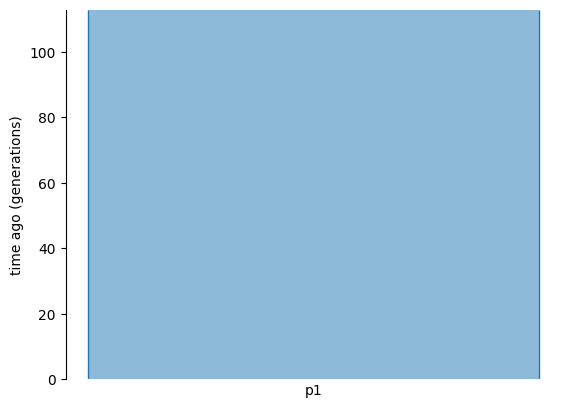

In [2]:
import msprime, demesdraw
import demesdraw
import matplotlib.pyplot as plt

demography = msprime.Demography()
demography.add_population(name="p1", initial_size=params["Ne"])
graph = msprime.Demography.to_demes(demography)
fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph, ax=ax, seed=1)
plt.show()

## Geneology simulation

In [3]:
replicates = msprime.sim_ancestry(
    samples=params["sample_size"],
    demography=demography,
    sequence_length=params["L"],
    num_replicates=params["num_chr"],
    recombination_rate=params["recombination_rate"],
    random_seed=params["seed"],
)
replicates = [
    msprime.sim_mutations(ts, rate=params["mutation_rate"], random_seed=params["seed"])
    for ts in replicates
]

## LD preprocessing

In [4]:
import sys, os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))
import ldbucket_tskit

In [5]:
datasets = [
    ldbucket_tskit.ldbucket(
        mts, name=f"seed_{i}", recombination_rate=params["recombination_rate"]
    )
    for i, mts in enumerate(replicates)
]

We re-arrange the data into a DataFrame and a numpy matrix. 

In [6]:
import pandas as pd

df = pd.concat(datasets)
df.head()

,contig_name,bin_index,left_bin,right_bin,mean
0,seed_0,0,0.005,0.010,0.007283
1,seed_0,1,0.010,0.015,0.004541
2,seed_0,2,0.015,0.020,0.003200
3,seed_0,3,0.020,0.025,0.002470
4,seed_0,4,0.025,0.030,0.001968


In [7]:
import numpy as np

observed_data = np.array([x["mean"] for x in datasets])
observed_data.shape

(10, 25)

# Model


Next, we define the (Bayesian) model assuming a constant $N_e$ demographic scenario. We will use a pseudo-likelihood by assuming the mean $\mathbb E[X_iX_jY_iY_j]$ per chromosome across every bin follows a normal distribution and estimate the variance from the data. 


In [8]:
import arviz as az
import pymc as pm
import pytensor.tensor as pt
from constant_population import predict_ld

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-darkgrid")

Running on PyMC v5.25.1


In [9]:
coords = {
    "contigs": df.contig_name.unique().astype(str),
    "bins": df.bin_index.unique().astype(int),
    "left_bins": df.left_bin.unique().astype(float),
    "right_bins": df.right_bin.unique().astype(float),
}
coords["midpoints"] = (coords["left_bins"] + coords["right_bins"]) / 2
nbins = len(coords["bins"])

In [10]:
with pm.Model(coords=coords) as model:
    # Set up prior on the population size so around
    # 90% of the mass probability is between 100 and 30000
    Ne = pm.Lognormal("Ne", mu=9.3, sigma=0.8)
    # Compute the expected vector of LD per bin
    u_i = coords["left_bins"]
    u_j = coords["right_bins"]
    mu = pm.Deterministic(
        "LD_mu", predict_ld(u_i, u_j, Ne, params["sample_size"]), dims="bins"
    )
    # Use the data to set up the prior on the covariance
    # Later code assumes `LD_obs` is defined
    obs = pm.Data("LD_obs", observed_data, dims=("contigs", "bins"))
    sigma2 = pm.Exponential("LD_sigma2", obs.var(axis=0), dims="bins")
    cov = pt.diag(sigma2)
    # Assume each bin follows a Normal distribution
    likelihood = pm.MvNormal("LD", mu, cov, observed=obs, dims=("contigs", "bins"))

## Sampling from the approximate posterior

In [11]:
with model:
    trace = pm.sample(random_seed=params["seed"])
az.summary(trace, var_names=["~LD_sigma2", "~LD_mu"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ne,4905.091,29.669,4845.85,4956.605,0.342,0.554,7642.0,3266.0,1.0


# Diagnosis

array([[<Axes: title={'center': 'Ne'}>, <Axes: title={'center': 'Ne'}>]],
      dtype=object)

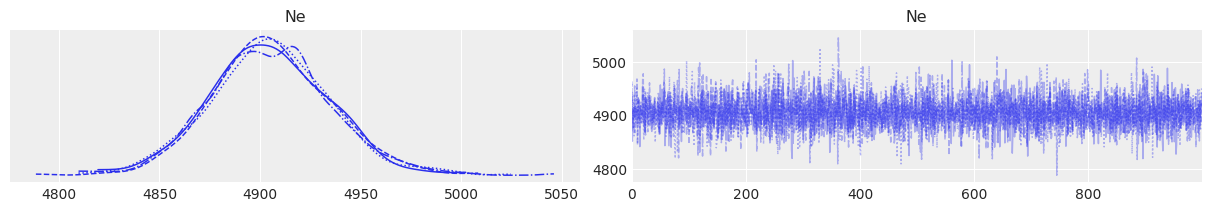

In [12]:
az.plot_trace(trace, var_names=["~LD_sigma2", "~LD_mu"])

## Posterior predictive distribution

In [13]:
with model.copy():
    LD_pp = pm.sample_posterior_predictive(trace)

Sampling: [LD]


Output()

Text(0, 0.5, '$E[X_i X_j Y_i Y_j]$')

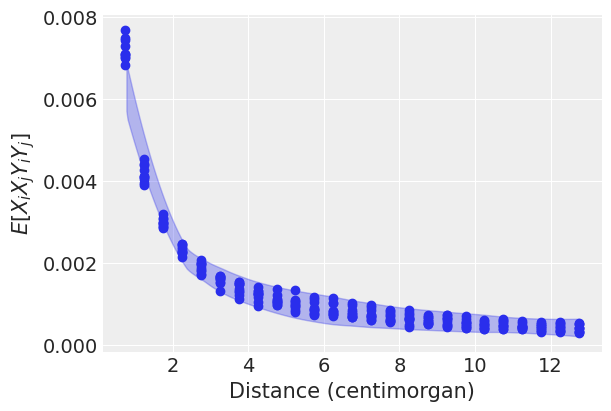

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
x = coords["midpoints"] * 100
hdi_data = az.hdi(
    LD_pp.posterior_predictive["LD"],
    input_core_dims=[["chain", "draw", "contigs"]],
)
az.plot_hdi(
    x,
    hdi_data=hdi_data,
    ax=ax,
    color="C0",
    fill_kwargs={"alpha": 0.3},
)
x_rep = np.repeat(x[None, :], params["num_chr"], axis=0)
ax.scatter(
    x_rep.flatten(),
    LD_pp.observed_data["LD"].values.flatten(),
)
ax.set_xlabel("Distance (centimorgan)")
ax.set_ylabel(r"$E[X_i X_j Y_i Y_j]$")

## Model evaluation using leave-one-out

In [15]:
with model:
    pm.compute_log_likelihood(trace)
loo = az.loo(trace)
loo

Output()

/Users/currocam/Documents/Dev/invasion-Ne-extras/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1889.80    17.17
p_loo       23.48        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        6   60.0%
   (0.70, 1]   (bad)         4   40.0%
   (1, Inf)   (very bad)    0    0.0%

Often, the diagnosis reports that the results are not reliable. In those cases, we can compute the ELPD-LOO exactly (although the values might not change).

In [16]:
from constant_population import ConstantPyMCModelWrapper

pymc_wrapper_constant = ConstantPyMCModelWrapper(model=model, idata_orig=trace)
loo_relooed = az.reloo(pymc_wrapper_constant, loo_orig=loo)
loo_relooed

/Users/currocam/Documents/Dev/invasion-Ne-extras/.venv/lib/python3.12/site-packages/arviz/stats/stats_refitting.py:100: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1887.51    18.40
p_loo       25.76        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       10  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<Axes: xlabel='elpd_loo (log)', ylabel='ranked models'>

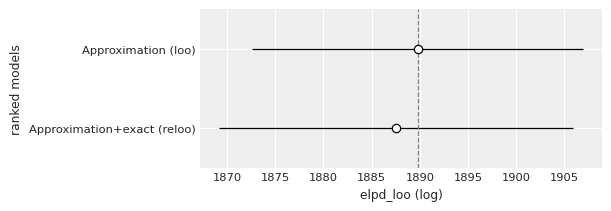

In [17]:
loo_df = az.compare(
    {"Approximation (loo)": loo, "Approximation+exact (reloo)": loo_relooed}
)
az.plot_compare(loo_df, title=False)